In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter('ignore')
from lib.methods import *


os.chdir('../')

2023-05-06 23:45:27.889691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class MRI8_NVF4_10mm_0p2mmVVV:
    CSV_FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
    VIDEO_FILE_DIR = './data/VF_FVF_DATASETS/VIDEO/'
    DATA_NAME = 'MRI8_NVF4_10mm_0p2mmVVV'
    SAMPLE_SPAN = [150000, 170000]
    FILTERING_CSV_METHODS = 'bandpass_filtering'
    BANDPASS_FILTERING_PARAMS = {
                    'passband_edge_freq':[100, 350], 
                    'stopband_edge_freq':[20, 800], 
                    'passband_edge_max_loss':1, 
                    'stopband_edge_min_loss':40
                    }
    LINE_SCANNING_PARAMS_VF = {'position':[50, 40],'width': 40}
    LINE_SCANNING_PARAMS_FVF = {'position':[70, 80],'width': 70}
    FILTERING_VIDEO_PARAMS_VF = {'kernel_length':10, 'kernel_size':3}
    FILTERING_VIDEO_PARAMS_FVF = {'kernel_length':10, 'kernel_size':3}

cfg = MRI8_NVF4_10mm_0p2mmVVV

In [3]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+'.csv', 
                                                                    data_name_list=['t', 'mic', 'flow'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

mic_t_data = csv_data_list[0]
mic_data = csv_data_list[1]
flow_data = csv_data_list[2]
video_vf_data = video_data_list[0]
video_fvf_data = video_data_list[1]
video_t_data = video_t_data_list[0]

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p2mmVVV.csv
data list | t, mic, flow
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p2mmVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p2mmVVV.avi


In [4]:
pp = PreProcessing(
                data=mic_data,
                t_data=mic_t_data,
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
pp.filter(
        method=cfg.FILTERING_CSV_METHODS, 
        params=cfg.BANDPASS_FILTERING_PARAMS
        )
pp.cut(sample_span=(5000, 15000))

mic_data_pp = pp.data
mic_t_data_pp = pp.t_data
video_vf_data_pp =  pp.video_data_list[0]
video_fvf_data_pp =  pp.video_data_list[1]
video_vf_t_data_pp = pp.video_t_data_list[0]
video_fvf_t_data_pp = pp.video_t_data_list[1]

In [26]:
class ProperOrthogonalDecomposition:
    def __init__(self, data):
        self.X = data
        self.Xis3D = False

        if self.X.ndim==3:
            self.Xis3D = True
            self.Xshape = self.X.shape
            self.X = self.X.reshape(self.Xshape[0], self.Xshape[1]*self.Xshape[2])

    def fit(self, method='Normal'):
        X = self.X
        
        ### Normal POD
        if method=='Normal':
            ### Covariance matrix: R
            R = X @ X.T
            ### Eigenvalue problem (Eigenvectors: phi, Eigenvalues:, lam)
            lam, phi = np.linalg.eigh(R) ### Solution of R @ phi =  lam @ phi
            lam = lam[np.argsort(lam)[::-1]] ### Sort descending
            phi = phi[np.argsort(lam)[::-1]] ### Sort descending

        ### Snapshot POD
        if method=='Snapshot':
            ### Covariance matrix: R
            R = X.T @ X
            ### Eigenvalue problem (Eigenvectors: u, Eigenvalues:, lam)
            lam, u = np.linalg.eigh(R) ### Solution of R @ u =  lam @ u
            lam = lam[np.argsort(lam)[::-1]] ### Sort descending
            u = u[np.argsort(lam)[::-1]] ### Sort descending
            ### Compute phi
            phi = (X@u)/np.sqrt(lam)

        return phi, lam, R

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def standardization_3d(data):
    (shape0, shape1, shape2) = data.shape
    SS = StandardScaler()
    return (SS.fit_transform(data.reshape(shape0, shape1*shape2))).reshape(shape0, shape1, shape2)

def normalization_3d(data):
    (shape0, shape1, shape2) = data.shape
    MMS = MinMaxScaler()
    return (MMS.fit_transform(data.reshape(shape0, shape1*shape2))).reshape(shape0, shape1, shape2)

In [130]:
video_vf_data_pp_normalized = normalization_3d(video_vf_data_pp)

In [7]:
video_vf_data_pp_normalized.shape

(7999, 112, 90)

In [139]:
X = video_vf_data_pp_normalized[:1000]

Xshape = X.shape
X = X.reshape(Xshape[0], Xshape[1]*Xshape[2])

In [140]:
### Covariance matrix
n = X.shape[0]
C = np.cov((X - np.mean(X, axis=0)).T)
C.shape

(10080, 10080)

In [141]:
### Eigenvalue problem (Eigenvector matrix: phi, Eigenvalue　matrix:, lam)
lam, phi = np.linalg.eig(C) ### Solution of "C @ phi = lam @ phi"
lam = lam[np.argsort(lam)[::-1]] ### Sort descending
phi = np.real(phi[:, np.argsort(lam)[::-1]]) ### Sort descending

print(lam.shape)
print(phi.shape)

(10080,)
(10080, 10080)


In [9]:
### SVD
n = X.shape[0]
U, S, V = np.linalg.svd(((X - np.mean(X, axis=0))), full_matrices=False)
VT = V.T

print(VT.shape)
print(S.shape)

(10080, 7999)
(7999,)


(7999,)
(7999,)


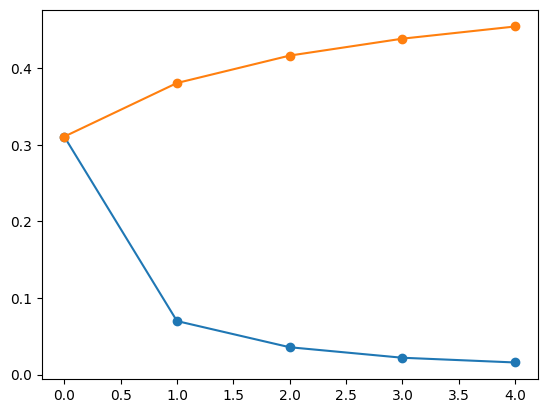

In [12]:
### Contribution rate (SVD)
lam = S**2 / (n-1)

rate = lam/np.sum(lam)
rate_cumsum = np.cumsum(lam)/np.sum(lam) ### Cumulative sum

print(rate.shape)
print(rate_cumsum.shape)

plt.plot(rate[:5], '-o')
plt.plot(rate_cumsum[:5], '-o')
plt.show()

In [13]:
### Principal component (SVD)
n_components = 2

r = n_components
Y = ((X - np.mean(X, axis=0))) @ VT[:, :r]

Y.shape

(7999, 2)

(10080,)
(10080,)


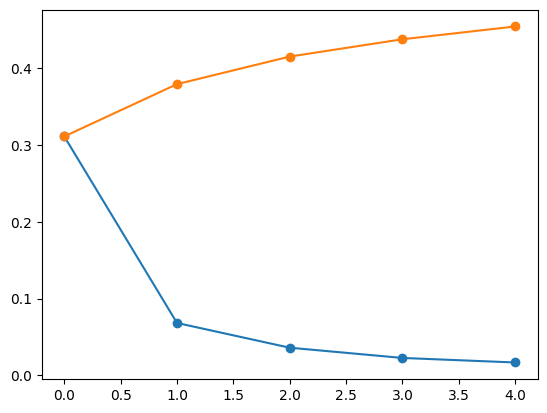

In [142]:
### Contribution rate
rate = lam/np.sum(lam)
rate_cumsum = np.cumsum(lam)/np.sum(lam) ### Cumulative sum

print(rate.shape)
print(rate_cumsum.shape)

plt.plot(rate[:5], '-o')
plt.plot(rate_cumsum[:5], '-o')
plt.show()

In [143]:
### Principal component
n_components = 10

r = n_components
Y = (X - np.mean(X, axis=0)) @ phi[:, :r]

Y.shape

(1000, 10)

In [144]:
Y_filtered = savgol_filtering(Y, window_length=51, polyorder=3)

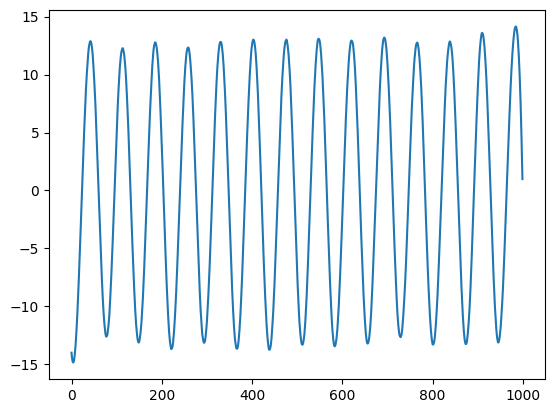

In [147]:
plt.plot(Y_filtered[:1000, 0])

In [91]:
### Reconstruct
n_components = 10
X_rec = (Y_filtered[:, :n_components] @ np.real(phi)[:, :n_components].T + np.mean(X, axis=0)).reshape(Xshape[0], Xshape[1], Xshape[2])

X_rec.shape

(7999, 112, 90)

In [95]:
Y_filtered[:, components].reshape(-1, 1).shape

(7999, 1)

In [128]:
### Reconstruct
components = 2
X_rec = (Y_filtered[:, components].reshape(-1, 1) @ np.real(phi)[:, components].reshape(-1, 1).T).reshape(Xshape[0], Xshape[1], Xshape[2])

X_rec.shape

(7999, 112, 90)

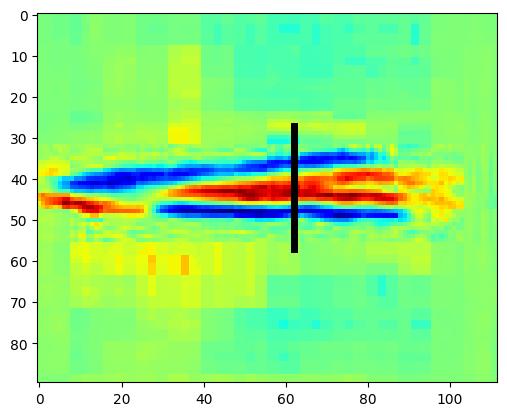

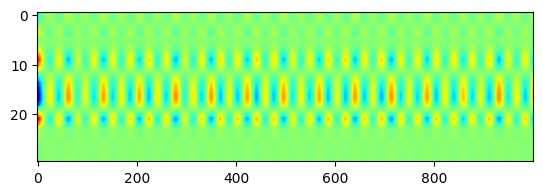

In [129]:
image = X_rec

position = [42, 50]
width = 30

x = X_rec.shape[1]
y = X_rec.shape[2]
a = position[0]
b = position[1]

plt.imshow(np.rot90(image[1000], -1), cmap='jet')
plt.plot([x-b, x-b], [a-int(width/2), a+int(width/2)], color='k', linewidth=5)
plt.show()

linescanned = line_scanning(X_rec, position, width)
plt.imshow(linescanned[:1000].T, cmap='jet', aspect=10)
plt.show()

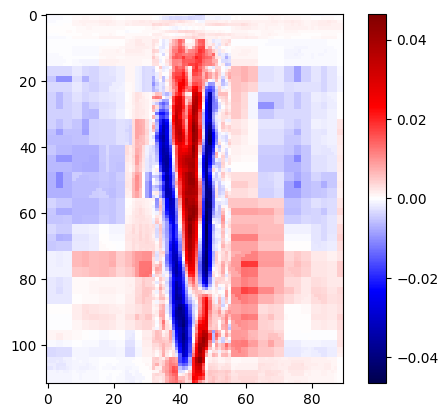

In [89]:
image = np.real(phi[:, 2]).reshape(Xshape[1], Xshape[2])
image_max = np.abs(np.max(image))
image_min = np.abs(np.min(image))
image_range = max(image_max, image_min)

plt.imshow(image, cmap='seismic', vmin=-image_range, vmax=image_range)
plt.colorbar()
